# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [48]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [49]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [50]:
# Rank the words existing, to figure out the words for stop-word.
from sklearn.feature_extraction.text import CountVectorizer 
movie_data = pd.read_csv('moviereviews_train.tsv', sep='\t')
texts = movie_data['review']
vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
sorted(words_freq, key = lambda x: x[1], reverse=True)

[('the', 336749),
 ('and', 164140),
 ('of', 145864),
 ('to', 135724),
 ('is', 107332),
 ('br', 101871),
 ('it', 96467),
 ('in', 93976),
 ('this', 76007),
 ('that', 73286),
 ('was', 48209),
 ('as', 46935),
 ('for', 44345),
 ('with', 44130),
 ('movie', 44047),
 ('but', 42623),
 ('film', 40159),
 ('you', 34267),
 ('on', 34202),
 ('not', 30632),
 ('he', 30155),
 ('are', 29438),
 ('his', 29376),
 ('have', 27731),
 ('be', 26957),
 ('one', 26795),
 ('all', 23985),
 ('at', 23516),
 ('they', 22915),
 ('by', 22548),
 ('an', 21564),
 ('who', 21441),
 ('so', 20614),
 ('from', 20499),
 ('like', 20281),
 ('there', 18865),
 ('her', 18424),
 ('or', 18007),
 ('just', 17774),
 ('about', 17375),
 ('out', 17113),
 ('if', 16809),
 ('has', 16791),
 ('what', 16168),
 ('some', 15749),
 ('good', 15147),
 ('can', 14677),
 ('more', 14252),
 ('she', 14228),
 ('when', 14184),
 ('very', 14067),
 ('up', 13293),
 ('time', 12727),
 ('no', 12716),
 ('even', 12655),
 ('my', 12504),
 ('would', 12436),
 ('which', 12051),


In [51]:
# Making Stop_words set to be applied
freqwords=sorted(words_freq, key = lambda x: x[1], reverse=True)
most_freqwords=freqwords[:10]
most_freqwords


[('the', 336749),
 ('and', 164140),
 ('of', 145864),
 ('to', 135724),
 ('is', 107332),
 ('br', 101871),
 ('it', 96467),
 ('in', 93976),
 ('this', 76007),
 ('that', 73286)]

In [52]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(10))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, stop_words=most_freqwords)
    X_hv = hv.fit_transform(movie_data.review)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    # Negative reviews tend to have the word 'waste' more than the favorable reviews.
    # This specific word is added to the feature set.
    movie_data['waste_count'] = movie_data['review'].str.count("waste")

    X_quant_features = movie_data[["word_count", "punc_count","waste_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = movie_data['sentiment']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [53]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=44)

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
        id  sentiment                                             review
0   5814_8          1  With all this stuff going down at the moment w...
1   2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2   7759_3          0  The film starts with a manager (Nicholas Bell)...
3   3630_4          0  It must be assumed that those who praised this...
4   9495_8          1  Superbly trashy and wondrously unpretentious 8...
5   8196_8          1  I dont know why people think this is such a ba...
6   7166_2          0  This movie could have been very good, but come...
7  10633_1          0  I watched this video at a friend's house. I'm ...
8    319_1          0  A friend of mine bought this film for £1, and ...
9  8713_10  

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [54]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 4865, 'TN': 5006, 'FP': 5007, 'FN': 5122, 'Accuracy': 0.49355, 'Precision': 0.49280794165316044, 'Recall': 0.4871332732552318, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [55]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 9986, 'TN': 10013, 'FP': 0, 'FN': 1, 'Accuracy': 0.99995, 'Precision': 1.0, 'Recall': 0.99989986983078, 'desc': 'svm_train'}


### MODEL: logistic regression

In [56]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 9987, 'TN': 10013, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [57]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 9572, 'TN': 9850, 'FP': 163, 'FN': 415, 'Accuracy': 0.9711, 'Precision': 0.983256291730868, 'Recall': 0.9584459797737058, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [58]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 9987, 'TN': 10013, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [86]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=40)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 9987, 'TN': 10013, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [60]:
# n_estimators - default value is 100. However, for the sake of clearer boundry,
# 150 is tried this time.

# max_features value: by reducing the number of features selection, give a greater variation
# among the trees generated. Default value is set 'auto'.If the change is dramatically big, it is going to be more than just avoiding overfit
# Current auto value is sqrt (n_features). therefore, sqrt(131075)=362.x
# For now, give a shot of 300.


In [88]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(n_estimators=80,max_depth=2,random_state=0, max_features =300)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9987, 'Neg': 10013, 'TP': 7446, 'TN': 7740, 'FP': 2273, 'FN': 2541, 'Accuracy': 0.7593, 'Precision': 0.7661282024899682, 'Recall': 0.7455692400120156, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

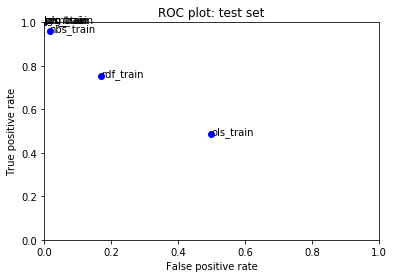

In [62]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [63]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [64]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
20
I really wanted to like this, but in the end it's a poorly made film with too few laughs.<br /><br />The politics are spot on, it's gonna offend the hell out of republicans but that's what it's designed to do. That alone gives me reason to chuckle.<br /><br />The problem is, it looks like it was made in a REAL hurry (like about a week). And it contains a stupid subplot about some bimbo singer, which seems to be completely off topic.<br /><br />Turiqistan is obviously Iraq, or Afghanistan, or any other number of countries the US has f**ked with since the 50s. The humour is a little dark (amputees dancing with prosthetic legs made by Tamerlane corporation) but it IS on the mark, especially with the corporations cashing in on the reconstruction (\democracy lite\"!) <br /><br />However like a lot of satire criticising the US, it seems terribly heavy handed and laboured. I guess it's running counter to so much bs propaganda so it has to bludgeon people over t

2069
I never saw the original 1954 version with Judy Garland, so have no means of comparison. Also, it's been some years, but I found this tale neither gripping nor its romance captivating. The movie tells the story of two lovers whose musical careers are headed in opposite directions. John Norman Howard is a worn out, disillusioned rock star on the decline, embarking upon a romance with a fresh, talented new singing sensation, Esther Hoffman. Her dramatic success only serves to emphasize his decline.<br /><br />The lead actors, Kris Kristofferson and Barbra Streisand, are adequate in their roles, but neither their chemistry nor the plot left much of a mark with me. The film is noteworthy to me for only one aspect, Streisand's beautiful rendition of the Oscar winning song 'Evergreen'. She truly has a powerful and magnificent voice.
* * * * * * * * * 
2351
What a long, drawn-out, pointless movie. I'm sure that historically this film is delightful but as entertainment goes it just doesn'

3158
Once upon a time there was a director by the name of James. He brought us wonderfully, thrilling science-fiction such as Terminator and Aliens. These movies were the stuff blockbusters were made of and he looked to have a fantastic future ahead of him as the dawn of computer generated special effects landed upon the film industry. Terminator 2 showed gave us glimpses of what was possible in this new era.<br /><br />.......and then it happened...................1997........countless awards..........obscene amounts of money............outlandish barrage of advertising............maximum profit margin........Titanic was here!<br /><br />I have never (ever) been one to jump on the bandwagon and be overly critical for the sake of it, in fact I have often taken the opposite stance from the majority just to get an argument going. Titanic however was a film I only took one single positive out of - that of Kate Winslett being absolutely gorgeous throughout!<br /><br />Quickly - the dialogu

5010
Spoilers? Maybe a few details, but nothing too plot related. Not like it would matter with this movie. <br /><br />Air Rage blatantly rips off the mid-air infiltration premise of Executive Decision. Ice-T leads a team of four \elite\" commandos who wear baggy black shirts that we can only imagine must conceal invisible body armor as their idiotic tactics (similar to what 3rd graders use when playing Star Wars on the playground) lead them to absorb a hail of gunfire. <br /><br />What entertained me the most about this flick was the use of look-alike has-been actors. You'll immediately recognize Cyril O'Reily as someone who once acted in a movie that you really liked, though it was so long ago that you probably won't be able to place it (it was Porky's). Here Cyril plays a decent knock-off of a Bill Paxton character. Most Hilarious is porker Gil Gerard, who's so fat that you will never recognize him as TV's Buck Rogers. Instead of evoking his mildly heroic character past, Gerard giv

6543
This might be the worst film ever made, and is possibly worth seeing for that reason alone. Streisand is laughably unbelievable as a young woman posing as a man in order to study Judaism. The soundtrack is torturous, featuring Barbara belting out some of the weakest blather ever put to film. And don't even get me started on the plot. You will actually get more chuckles out of this film than many comedies because it is soooooooo terrible. The rampant ego of Streisand, thinking she could somehow raise this stinker to Oscar heights, led to this disaster. I'm pretty sure the novelist, Isaac Bashevis Singer, hated this film and never forgave Streisand. I can't blame him. This movie is like watching a car wreck in slow motion for two hours with the soundtrack of 'The Sound of Music' being played backwards on an old turntable. It's truly that bad. I'm amazed that anyone from Streisand enjoyed this movie on the level that it was intended.
* * * * * * * * * 
6663
I remember watching this m

8516
This juvenile, bland flick is strictly for teenagers in old mens' bodies, desperate to relive their hormonally challenged teenage years. How ? By burning up gas and equating a fast, reckless car (or plane) with freedom.<br /><br />The plot borrows heavily from Mister Rogers' neighborhood (if it were run my an oil conglomerate) and Logan's Run (if it were heavily sedated and lacked a clear sense of style).<br /><br />Starring Lee Majors and Burgess Meredith this film is set in a post-gas-crisis world in which an all-powerful government doesn't want you to (*ahem*) drive your car and burn gas. Sort of the opposite of today's Enron-and-Bush, oil-grabbing, SUV-pushing government.<br /><br />This juxtaposition alone makes the film laughable. But wait...there's more. Although the film is set in the future, we're not shown any signs of future technology, beyond a return to bicycles, golf carts and horses. You will believe that the future looks... exactly like today. Same clothing, same s

10429
This is some of the worst acting I have ever seen. I love Almereyda's Nadja, but this is just absolute dreck. Aside from a few moments of interesting cinematography and music this film is just nonstop bad acting and dumb material. Jared Harris is particularly bad, but no one in this is remotely good. The plot is a joke, but not the haha kind. I don't even know if you can forgive movies that are this bad. Please erase the last hour and a half of my life. How did this director make Nadja and Another Girl Another Planet?
* * * * * * * * * 
10473
Given the title and outlandish box art, I was ready for just about anything. Perhaps my expectation were forced just a bit to high, because I was left a little dry.<br /><br />A film crew working on a soft-core sex movie end up at a strange house when they get lost in the fog and decide the best way to spend the evening is to have sex. Where hasn't this set up been used before? The difference here is the uber-perverse nature of the sex. Not 

11644
Trust me, this is one let down movie that you want to avoid and this comes from one huge Denzel Washington fan. The frustrating part is that it's 1/3 of a GREAT film. The first part of this movie does an exceptional job of setting up the characters and the new relationship between Creasy and the girl he's paid to protect. The trailers to this movie all mention that she is kidnapped. So, I'm giving nothing away when I say that the film degenerates into an almost unwatchable mess after she's kidnapped. Whatever the director was trying to accomplish, all he succeeds in doing is making the audience literally nauseous. Rapid, frantic and choppy cuts follow for the next half-hour as Creasy tracks down the perpetrators. These cuts are so unnatural and nauseating that all they do is to jolt you out of the story. I'm sure the director thought that this unsettling way to present the story signified a change in Creasy's character and signified that a different movie was to follow. Well, he 

13687
I am completely baffled as to why this film is even liked, let alone held in such high regard, especially by so many critics who are, otherwise, quite sensible.<br /><br />There is one key word which describes this film to its core - irritating.<br /><br />The most easily explained example of this is the director's use - or, more accurately, abuse - of music. In the first half, a really dull reggae tune is played about three times (when once is too often). But in the second half, The Mommas And The Papas \California Dreamin'\" is played at least seven times, usually at top volume. Godsakes, whether you liked the song or not beforehand, you'd be thoroughly sick of it by the end. Just think, some people claim to have seen this film four or five times. This means they've listened to California Dreamin either 28 or 35 times.....<br /><br />All of this needless hyper-repetition (it contributes nothing to the story) could possibly be excused if the remainder of the film had any lingeri

15965
What I found so curious about this film--I saw the full 4 hour roadshow version, is how oddly dispassionate it is. For a film about 2 very charismatic men--Castro and Che, engaged in a gargantuan political struggle, it's almost totally devoid of emotional fire. The scenes between Benicio Del Toro and Demian Bichir (who is at best a second level actor,with a slightly high pitched voice) have no drama or depth and basically come down to Castro telling Che: go here, go there, do this and that, with no explanation as to what effect or use this action will result in. Odder still is there is an actor in the cast who has the requisite power to play Castro--Joaquim de Almeida, but he's shunted aside in a minor part in the second half. Without the tension or passion that you would expect to fire these men and their followers, the film becomes a dullish epic-length film about hairy, bearded men running through various jungles shouting and shooting to no particular purpose or end. Several o

18022
If they could get Ed Asner why didn't they get other actors instead of people who go to the same church as the producers? And why did the protagonist throw the wise old sage character to the ground when he was never in danger. It forced the old guy to mask the injury out of pride and so the young guy would feel guilty leaving him with a life long disability. I guess thats why the main character refuses money though and why the old guy works him like a dog even when he volunteers for extra work. If the d-bag boyfriend is a bad guy because he is long-distance boyfriend then why is a soldier any better. He has good reason to be jealous, good reason to get her away from her hometown and over protective, controlling manipulative father. All the characters that are meant to be likable aren't and everyone else is the 'bad' boyfriend. How did they meet anyway, a wine broker and a saw mill worker?
* * * * * * * * * 
18052
This is a bad movie. Not one of the funny bad ones either. This is 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [65]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 1233, 'TN': 1240, 'FP': 1247, 'FN': 1280, 'Accuracy': 0.4946, 'Precision': 0.4971774193548387, 'Recall': 0.49064862713887786, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [66]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 2126, 'TN': 2071, 'FP': 416, 'FN': 387, 'Accuracy': 0.8394, 'Precision': 0.8363493312352478, 'Recall': 0.8460007958615201, 'desc': 'svm_test'}


### MODEL: logistic regression

In [67]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 2105, 'TN': 2044, 'FP': 443, 'FN': 408, 'Accuracy': 0.8298, 'Precision': 0.826138147566719, 'Recall': 0.8376442499005173, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [68]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 1838, 'TN': 1834, 'FP': 653, 'FN': 675, 'Accuracy': 0.7344, 'Precision': 0.7378562826174228, 'Recall': 0.7313967369677676, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [69]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 2103, 'TN': 2069, 'FP': 418, 'FN': 410, 'Accuracy': 0.8344, 'Precision': 0.8341927806426022, 'Recall': 0.8368483883804219, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [70]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 2165, 'TN': 2073, 'FP': 414, 'FN': 348, 'Accuracy': 0.8476, 'Precision': 0.8394726638231873, 'Recall': 0.8615200955033824, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [71]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2513, 'Neg': 2487, 'TP': 1823, 'TN': 2018, 'FP': 469, 'FN': 690, 'Accuracy': 0.7682, 'Precision': 0.7953752181500873, 'Recall': 0.7254277755670513, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

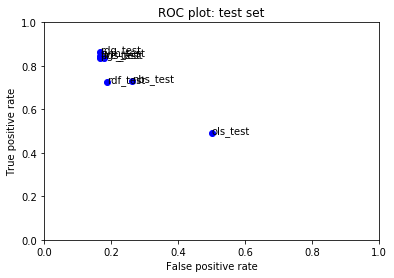

In [72]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [73]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=44, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
5    2913_8  ...as valuable as King Tut's tomb! (OK, maybe ...
6    4396_1  This has to be one of the biggest misfires eve...
7     395_2  This is one of those movies I watched, and won...
8   10616_1  The worst movie i've seen in years (and i've s...
9    9074_9  Five medical students (Kevin Bacon, David Labr...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [91]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdf.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.4824


In [75]:
raw_data.head()

,id,review,word_count,punc_count,waste_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5,0
1,8348_2,This movie is a disaster within a disaster fil...,169,15,1
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18,0
3,7186_2,Afraid of the Dark left me with the impression...,112,5,0
4,12128_7,A very accurate depiction of small time mob li...,133,8,0


In [76]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,1
3,7186_2,0
4,12128_7,1


In [77]:
my_submission.shape

(25000, 2)

In [78]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('./sample_submissions/moviereviews_sample_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation